In [1]:
pip install hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 10.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import anderson
import scipy.stats as stats



In [3]:
df=pd.read_csv('Amazon Sale Report.csv',header='infer')
df.drop('index',axis=1,inplace=True)
df.drop('New',axis=1,inplace=True)
df.drop('PendingS',axis=1,inplace=True)

In [4]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128976 entries, 0 to 128975
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Order ID            128976 non-null  object 
 1   Date                128976 non-null  object 
 2   Status              128976 non-null  object 
 3   Fulfilment          128976 non-null  object 
 4   Sales Channel       128976 non-null  object 
 5   ship-service-level  128976 non-null  object 
 6   Category            128976 non-null  object 
 7   Size                128976 non-null  object 
 8   Courier Status      128976 non-null  object 
 9   Qty                 128976 non-null  int64  
 10  currency            121176 non-null  object 
 11  Amount              121176 non-null  float64
 12  ship-city           128941 non-null  object 
 13  ship-state          128941 non-null  object 
 14  ship-postal-code    128941 non-null  float64
 15  ship-country        128941 non-nul

Order ID              120229
Date                      91
Status                    13
Fulfilment                 2
Sales Channel              2
ship-service-level         2
Category                   9
Size                      11
Courier Status             4
Qty                       10
currency                   1
Amount                  1408
ship-city               8948
ship-state                69
ship-postal-code        9454
ship-country               1
B2B                        2
fulfilled-by               1
dtype: int64

In [5]:
df.isnull().sum()

Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales Channel             0
ship-service-level        0
Category                  0
Size                      0
Courier Status            0
Qty                       0
currency               7800
Amount                 7800
ship-city                35
ship-state               35
ship-postal-code         35
ship-country             35
B2B                       0
fulfilled-by          89713
dtype: int64

In [6]:
mean_amount=df['Amount'].mean()
mode_city = df['ship-city'].mode()
mode_state = df['ship-state'].mode()

df['Amount'].fillna(mean_amount, inplace=True)

if not mode_city.empty:
    df['ship-city'].fillna(mode_city[0], inplace=True)

if not mode_state.empty:
    df['ship-state'].fillna(mode_state[0], inplace=True)
mode_code=df['ship-postal-code'].mode()

if not mode_code.empty:
    df['ship-postal-code'].fillna(mode_code[0], inplace=True)

df['ship-country'].fillna('International',inplace=True)
df['fulfilled-by'].fillna('Unknown',inplace=True)
df['currency'].fillna('Not given',inplace=True)
df.isnull().sum()

<ipython-input-6-61247107>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Amount'].fillna(mean_amount, inplace=True)
<ipython-input-6-61247107>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method

Order ID              0
Date                  0
Status                0
Fulfilment            0
Sales Channel         0
ship-service-level    0
Category              0
Size                  0
Courier Status        0
Qty                   0
currency              0
Amount                0
ship-city             0
ship-state            0
ship-postal-code      0
ship-country          0
B2B                   0
fulfilled-by          0
dtype: int64

In [7]:
sp= sorted(df['Date'].unique())
print("start date:",sp[0])
print("ending date:",sp[-1])
print("Duration:",pd.to_datetime(sp[-1]) - pd.to_datetime(sp[0]))

start date: 03-31-22
ending date: 06-29-22
Duration: 90 days 00:00:00


In [8]:
df['Date']=pd.to_datetime(df['Date'])
sp= sorted(df['Date'].unique())
reference_Date = sp[-1]
pending_rows=df[df['Status']=='Pending']
pending_rows['TimeDuration']=reference_Date-pending_rows['Date']
time_durations=pending_rows['TimeDuration'].to_numpy()
time_durations_days=time_durations/np.timedelta64(1, 'D')
unique_sorted_durations = np.sort(np.unique(time_durations_days))
print(unique_sorted_durations)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 25. 34. 36. 44. 52.
 57. 86.]


<ipython-input-8-522626461>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])
<ipython-input-8-522626461>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pending_rows['TimeDuration']=reference_Date-pending_rows['Date']


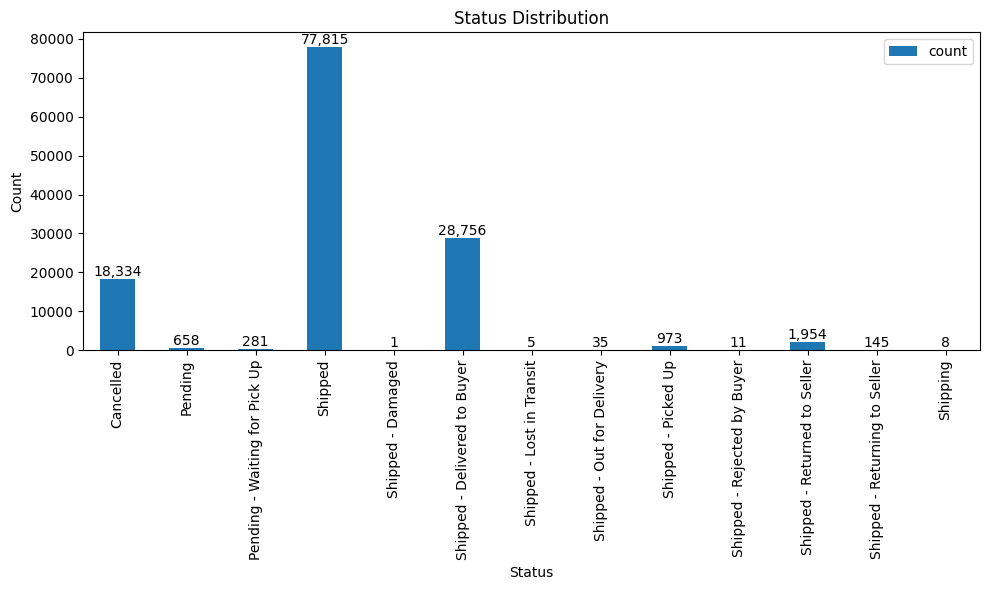

In [9]:
plt.figure(figsize=(10, 6))
counts=df['Status'].value_counts().sort_index()
ax=counts.plot(kind='bar')
for i, value in enumerate(counts):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.title('Status Distribution')
plt.xlabel("Status")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

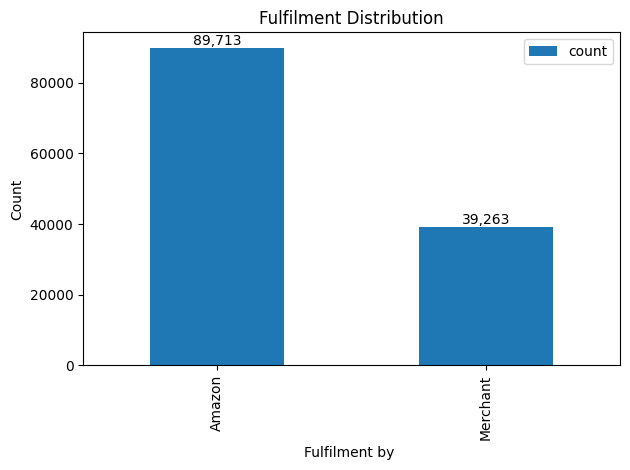

Amazon percentage: 69.55790224537898 %
Merchant percentage: 30.442097754621017 %


<ipython-input-10-1633976601>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Amazon percentage:",(counts[0]/(counts[0]+counts[1]))*100,"%")
<ipython-input-10-1633976601>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Merchant percentage:",counts[1]/(counts[0]+counts[1])*100,"%")


In [10]:
counts=df['Fulfilment'].value_counts().sort_index()
ax=counts.plot(kind='bar')
for i, value in enumerate(counts):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.title('Fulfilment Distribution')
plt.xlabel("Fulfilment by ")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

print("Amazon percentage:",(counts[0]/(counts[0]+counts[1]))*100,"%")
print("Merchant percentage:",counts[1]/(counts[0]+counts[1])*100,"%")

In [11]:
df['Sales Channel'].value_counts()

Sales Channel
Amazon.in     128852
Non-Amazon       124
Name: count, dtype: int64

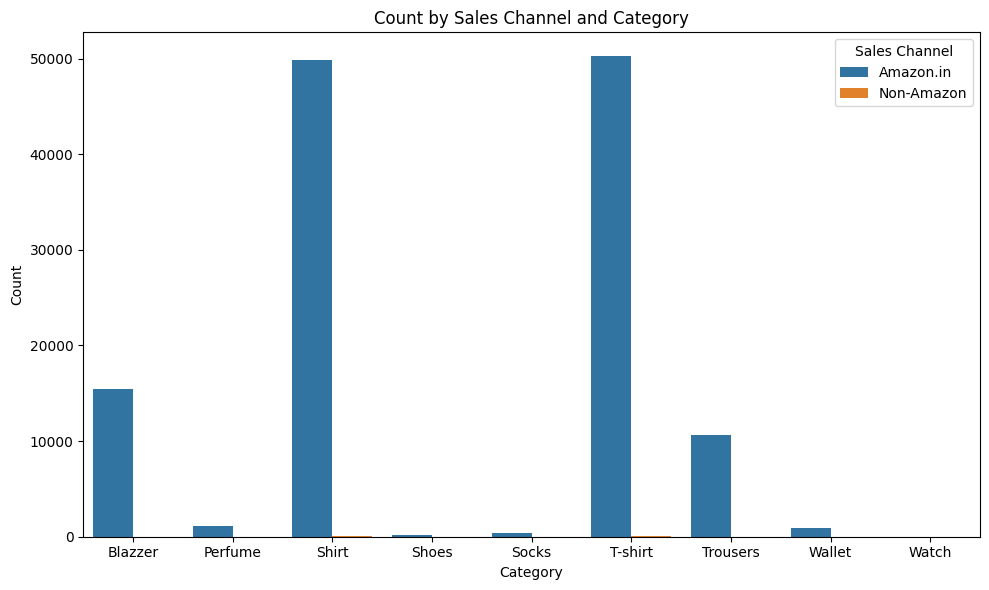

In [12]:
# Group by 'Category' and 'Sales Channel' and count the occurrences
count_data = df.groupby(['Category', 'Sales Channel']).size().reset_index(name='Count')

# Plot`
plt.figure(figsize=(10, 6))
sns.barplot(data=count_data, x='Category', y='Count', hue='Sales Channel')
plt.title('Count by Sales Channel and Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [13]:
df.hvplot.scatter(x='Category',y='Amount',by='Sales Channel')

:NdOverlay   [Sales Channel]
   :Scatter   [Category]   (Amount)

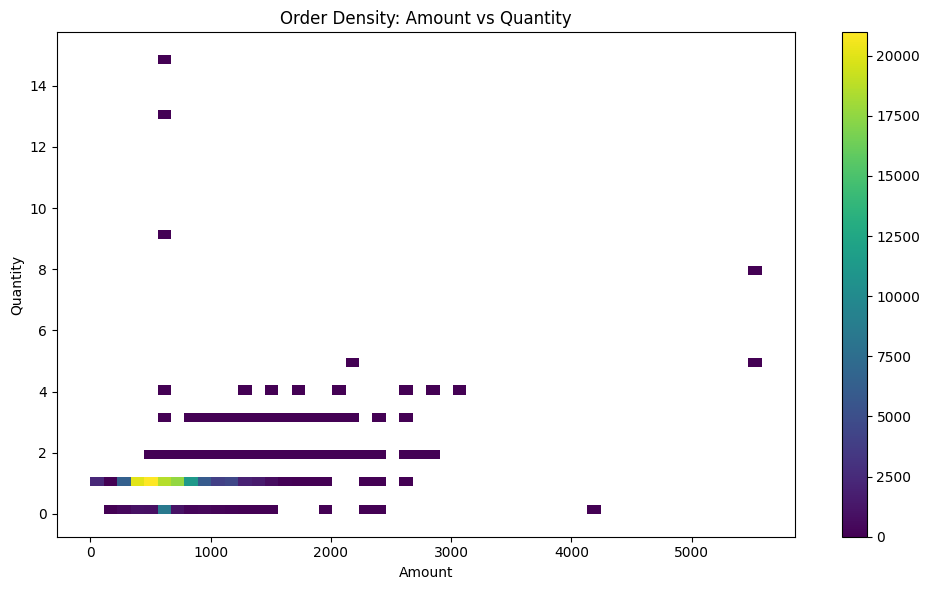

In [14]:
# Ensure Amount and Qty are numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')

# Drop rows with missing or invalid values
df_clean = df.dropna(subset=['Amount', 'Qty'])

# Plot using seaborn's 2D histogram heatmap
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='Amount',
    y='Qty',
    bins=50,
    cmap='viridis',
    cbar=True
)
plt.title('Order Density: Amount vs Quantity')
plt.xlabel('Amount')
plt.ylabel('Quantity')
plt.tight_layout()
plt.show()


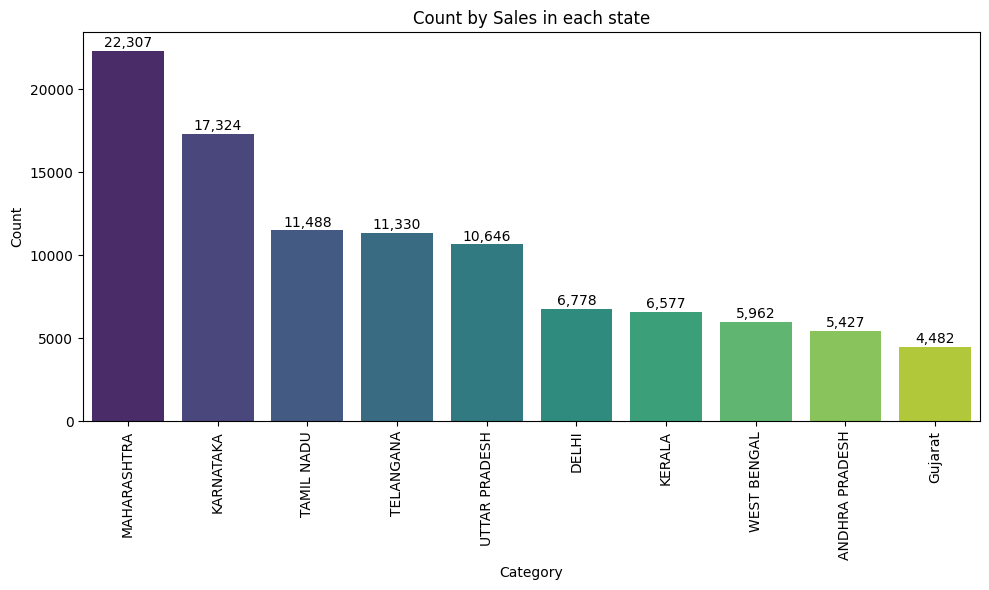

In [15]:
state_counts=df['ship-state'].value_counts().head(10).reset_index()
state_counts.columns = ['ship-state', 'count']
plt.figure(figsize=(10, 6))
ax=sns.barplot(data=state_counts, x='ship-state', y='count',hue='ship-state',palette='viridis',legend= False)
plt.title('Count by Sales in each state')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i, value in enumerate(state_counts['count']):
  ax.text(i, value+50, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

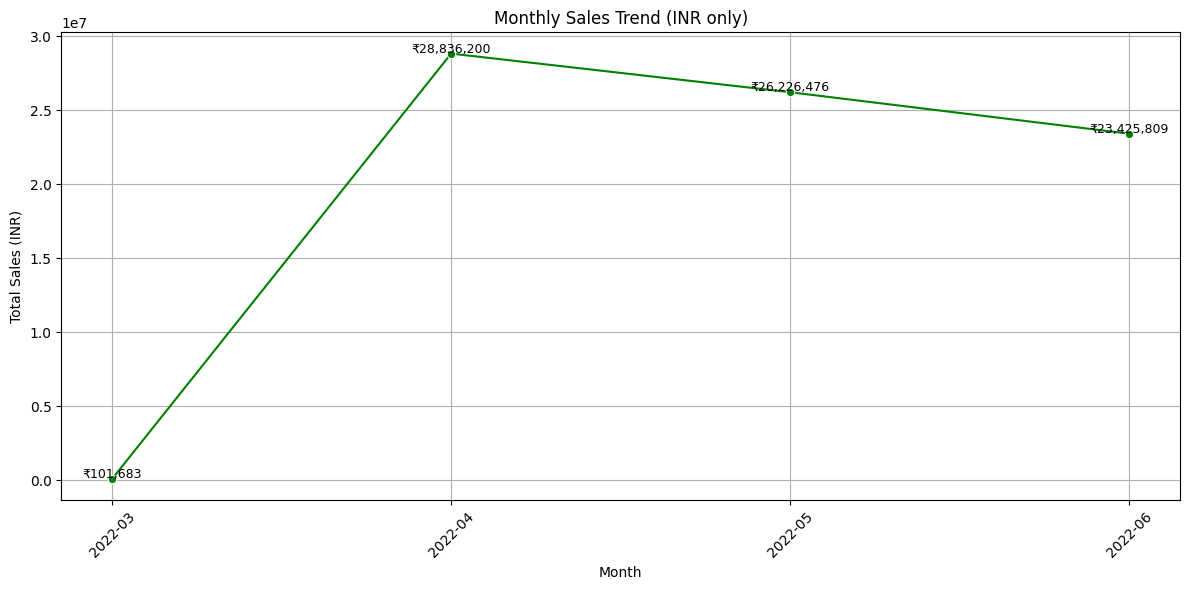

In [16]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Filter only rows where currency is INR
df = df[df['currency'] == 'INR']

# Drop rows with missing 'Amount'
df = df.dropna(subset=['Amount'])

# Create 'Month' column
df['Month'] = df['Date'].dt.to_period('M').astype(str)

# Calculate monthly total INR sales
monthly_sales = df.groupby('Month')['Amount'].sum().reset_index()

# Plot monthly sales trend (INR only)
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Amount', marker='o', color='green')

# Add value labels
for i, row in monthly_sales.iterrows():
    plt.text(i, row['Amount'] + 50000, f"₹{int(row['Amount']):,}", ha='center', fontsize=9)

plt.title('Monthly Sales Trend (INR only)')
plt.xlabel('Month')
plt.ylabel('Total Sales (INR)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

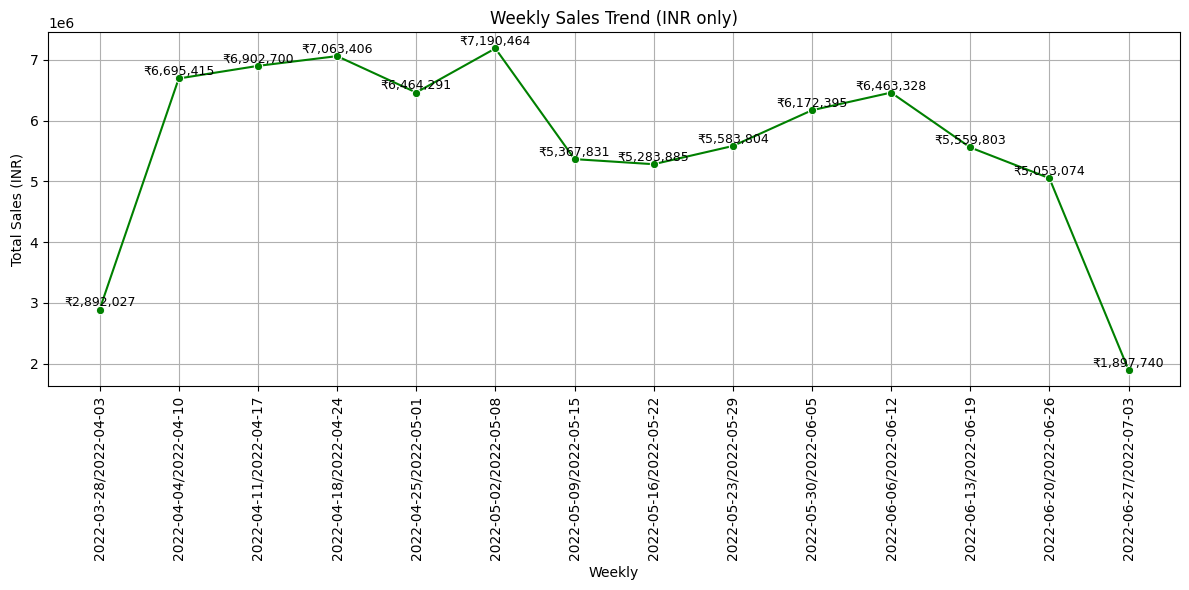

In [17]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

# Filter only rows where currency is INR
df = df[df['currency'] == 'INR']

# Drop rows with missing 'Amount'
df = df.dropna(subset=['Amount'])

# Create 'Month' column
df['Week'] = df['Date'].dt.to_period('W').astype(str)

# Calculate monthly total INR sales
monthly_sales = df.groupby('Week')['Amount'].sum().reset_index()

# Plot monthly sales trend (INR only)
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Week', y='Amount', marker='o', color='green')

# Add value labels
for i, row in monthly_sales.iterrows():
    plt.text(i, row['Amount'] + 50000, f"₹{int(row['Amount']):,}", ha='center', fontsize=9)

plt.title('Weekly Sales Trend (INR only)')
plt.xlabel('Weekly')
plt.ylabel('Total Sales (INR)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
df['currency'].unique()
df['ship-city'].nunique()

8697

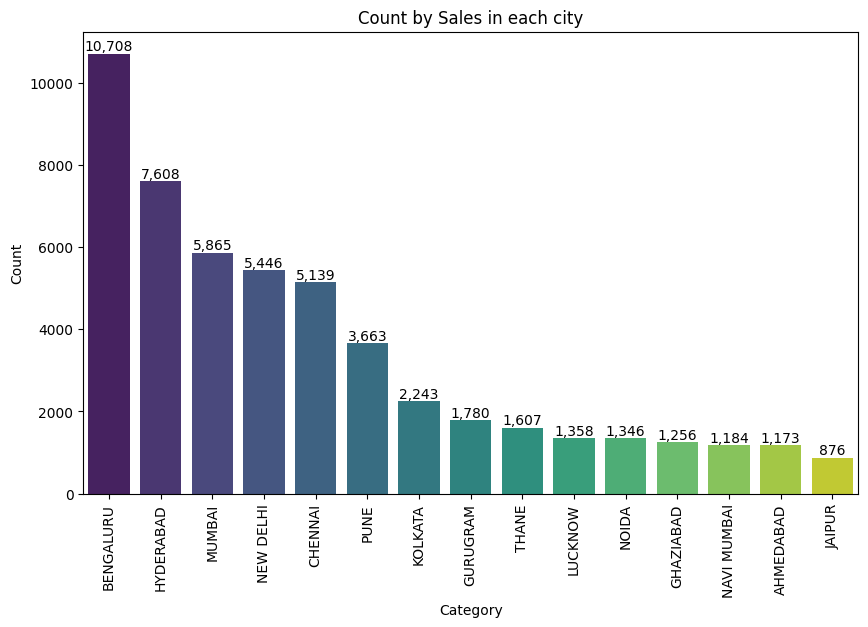

In [19]:
state_counts=df['ship-city'].value_counts().head(15).reset_index()
plt.figure(figsize=(10, 6))
state_counts.columns = ['ship-city', 'count']
ax=sns.barplot(data=state_counts, x='ship-city', y='count',hue='ship-city',palette='viridis',legend= False)
plt.title('Count by Sales in each city')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i, value in enumerate(state_counts['count']):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.show()

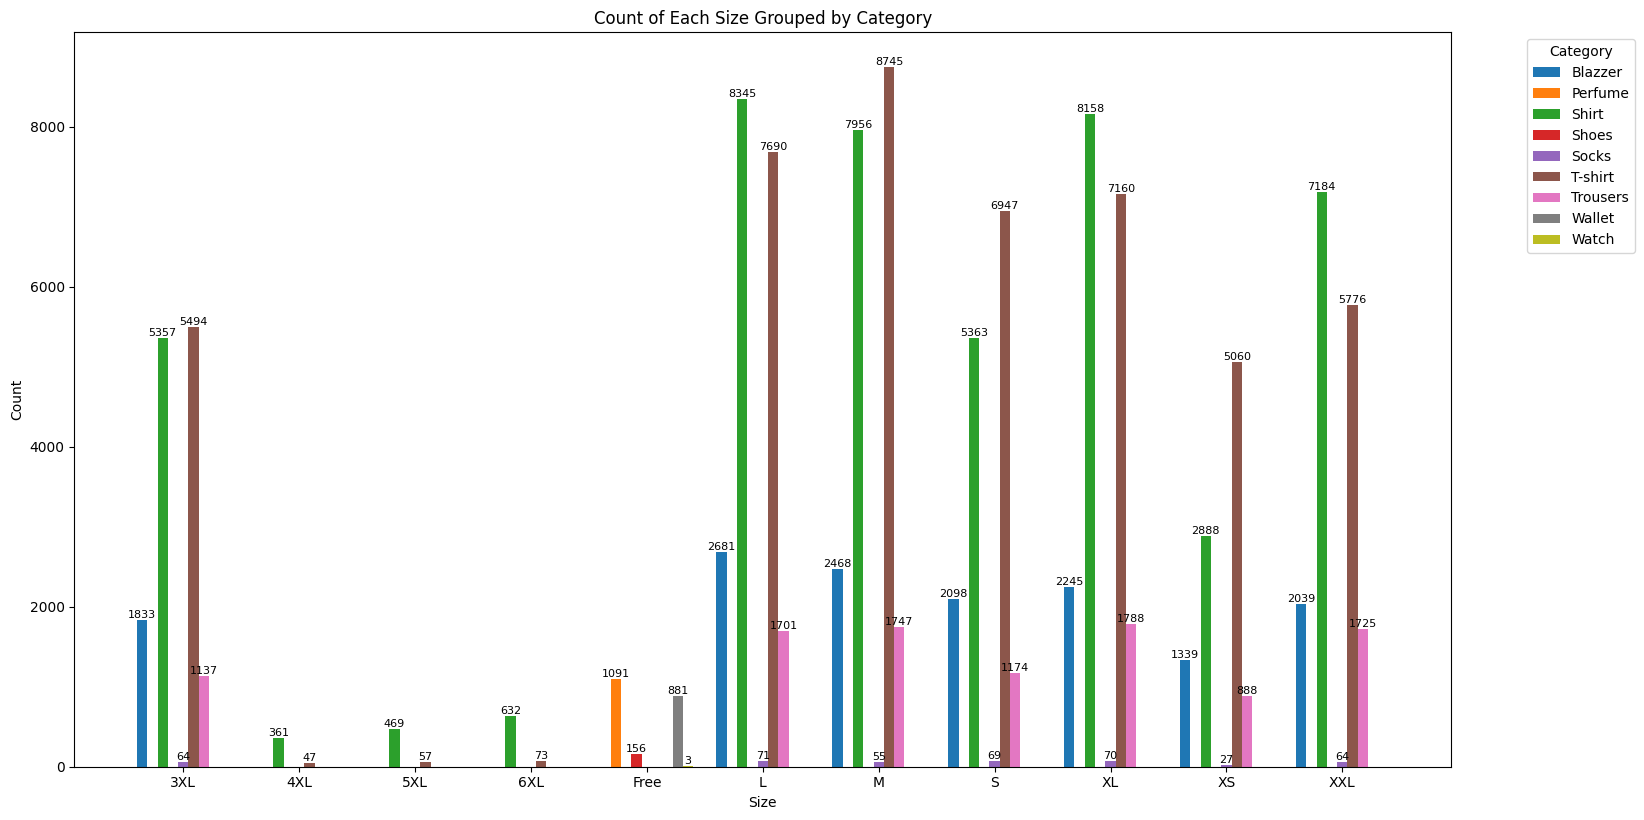

In [20]:
# Drop missing values
df = df.dropna(subset=['Category', 'Size'])

# Group by Size and Category and count
size_counts = df.groupby(['Size', 'Category']).size().reset_index(name='Count')

# Pivot for grouped bar chart
pivot_table = size_counts.pivot(index='Size', columns='Category', values='Count').fillna(0)

# Get sizes and categories
sizes = pivot_table.index
categories = pivot_table.columns
x = np.arange(len(sizes))
bar_width = 0.8 / len(categories)

# Plot setup
fig, ax = plt.subplots(figsize=(len(sizes)*1.5, len(categories)*0.7 + 2))

# Plot vertical bars for each category, grouped by size
for i, category in enumerate(categories):
    counts = pivot_table[category].values
    positions = x + i * bar_width
    bars = ax.bar(positions, counts, width=bar_width, label=category)

    # Add count labels on top
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{int(height)}',
                    ha='center', va='bottom', fontsize=8)

# Configure axes
ax.set_xticks(x + bar_width * (len(categories)-1)/2)
ax.set_xticklabels(sizes, rotation=0)
ax.set_xlabel("Size")
ax.set_ylabel("Count")
ax.set_title("Count of Each Size Grouped by Category")
ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


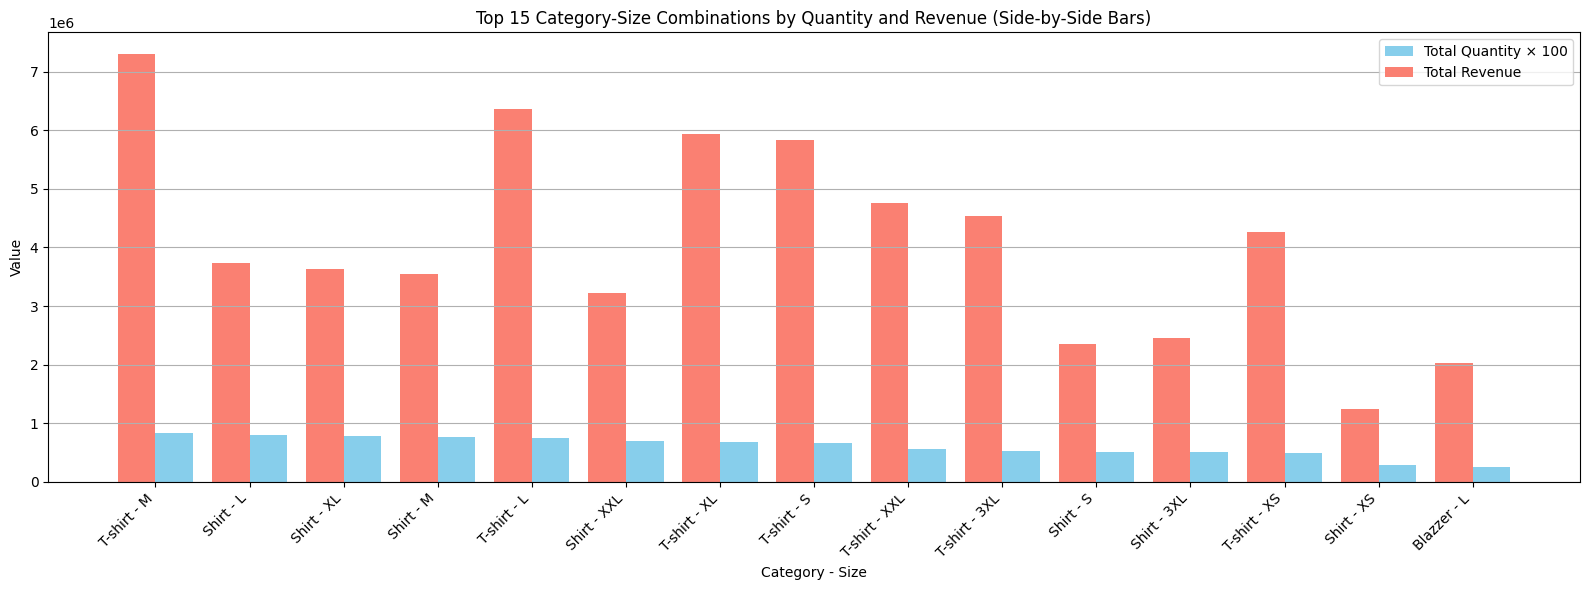

In [21]:
# Clean data
df_clean = df.dropna(subset=['Category', 'Size', 'Amount'])

# Group and summarize
category_size_summary = df_clean.groupby(['Category', 'Size']).agg(
    Total_Quantity=('Qty', lambda x: x.sum() * 100),  # correct usage
    Total_Revenue=('Amount', 'sum')
).reset_index()

# Get top 15 by Total Quantity
top_combo = category_size_summary.sort_values(by='Total_Quantity', ascending=False).head(15)

# Create a label for x-axis
top_combo['Label'] = top_combo['Category'] + " - " + top_combo['Size']

# Set positions for side-by-side bars
x = np.arange(len(top_combo))
bar_width = 0.4

# Plotting
plt.figure(figsize=(16, 6))

# Bar for Quantity
plt.bar(x + bar_width/2, top_combo['Total_Quantity'], width=bar_width, label='Total Quantity × 100', color='skyblue')

# Bar for Revenue
plt.bar(x - bar_width/2, top_combo['Total_Revenue'], width=bar_width, label='Total Revenue', color='salmon')

# Customizing axes
plt.xticks(ticks=x, labels=top_combo['Label'], rotation=45, ha='right')
plt.xlabel('Category - Size')
plt.ylabel('Value')
plt.title('Top 15 Category-Size Combinations by Quantity and Revenue (Side-by-Side Bars)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


  Sales Channel  Total_Orders  Total_Revenue
0     Amazon.in        116479    78590170.25


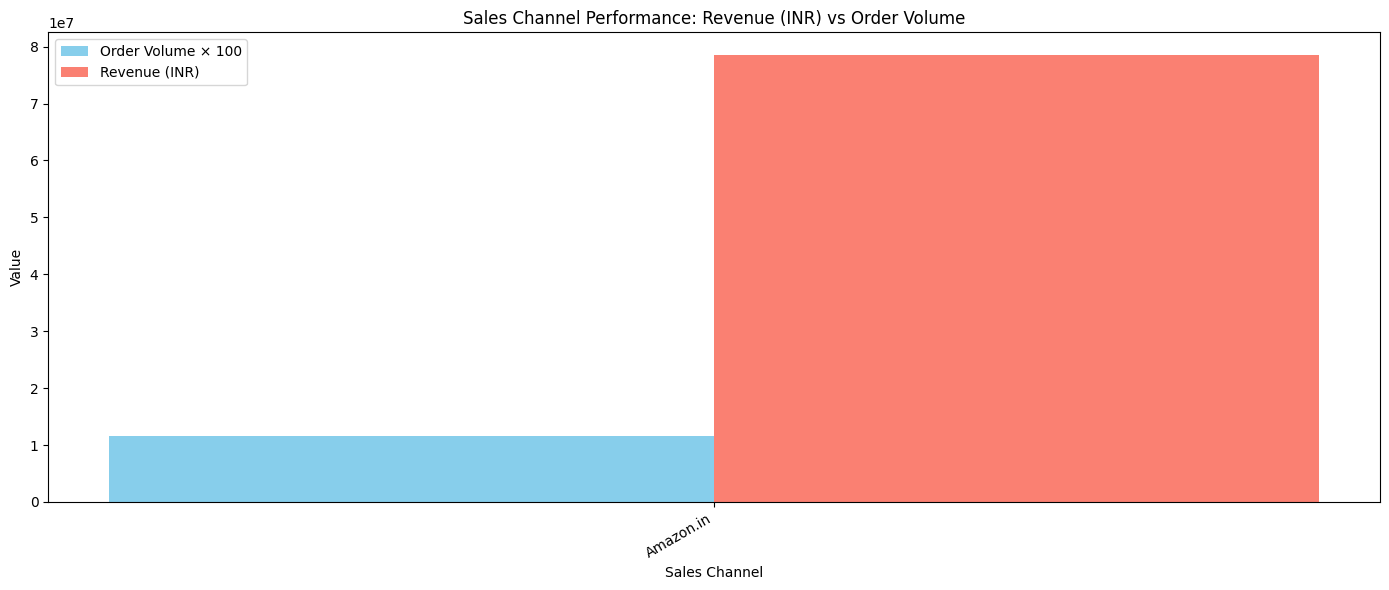

In [22]:
# Filter INR transactions only
df_inr = df.dropna(subset=['Sales Channel', 'Amount', 'Qty', 'currency'])
df_inr = df_inr[df_inr['currency'] == 'INR']

# Group by Sales Channel
channel_summary = df_inr.groupby('Sales Channel').agg(
    Total_Orders=('Qty', 'sum'),
    Total_Revenue=('Amount', 'sum')
).reset_index()
print(channel_summary)
# Sort by revenue
channel_summary = channel_summary.sort_values(by='Total_Revenue', ascending=False).reset_index(drop=True)

# Plot
x = np.arange(len(channel_summary))
bar_width = 0.4

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width/2, channel_summary['Total_Orders'] * 100, width=bar_width, color='skyblue', label='Order Volume × 100')
plt.bar(x + bar_width/2, channel_summary['Total_Revenue'], width=bar_width, color='salmon', label='Revenue (INR)')

plt.xticks(x, channel_summary['Sales Channel'], rotation=30, ha='right')
plt.ylabel("Value")
plt.xlabel("Sales Channel")
plt.title("Sales Channel Performance: Revenue (INR) vs Order Volume")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# Filter only INR transactions
df_inr = df[df['currency'] == 'INR'].dropna(subset=['B2B', 'Amount', 'Qty'])

# Group by B2B type
b2b_summary = df_inr.groupby('B2B').agg(
    Total_Sales=('Amount', 'sum'),
    Total_Quantity=('Qty', 'sum'),
    Order_Count=('Qty', 'count')  # Assuming each row is an order
).reset_index()

# Calculate Average Order Value (AOV)
b2b_summary['AOV'] = b2b_summary['Total_Sales'] / b2b_summary['Order_Count']

# Format currency nicely (optional)
b2b_summary['Total_Sales'] = b2b_summary['Total_Sales'].round(2)
b2b_summary['AOV'] = b2b_summary['AOV'].round(2)

print(b2b_summary)

     B2B  Total_Sales  Total_Quantity  Order_Count     AOV
0  False  77998690.46          115638       120332  648.20
1   True    591479.79             841          844  700.81


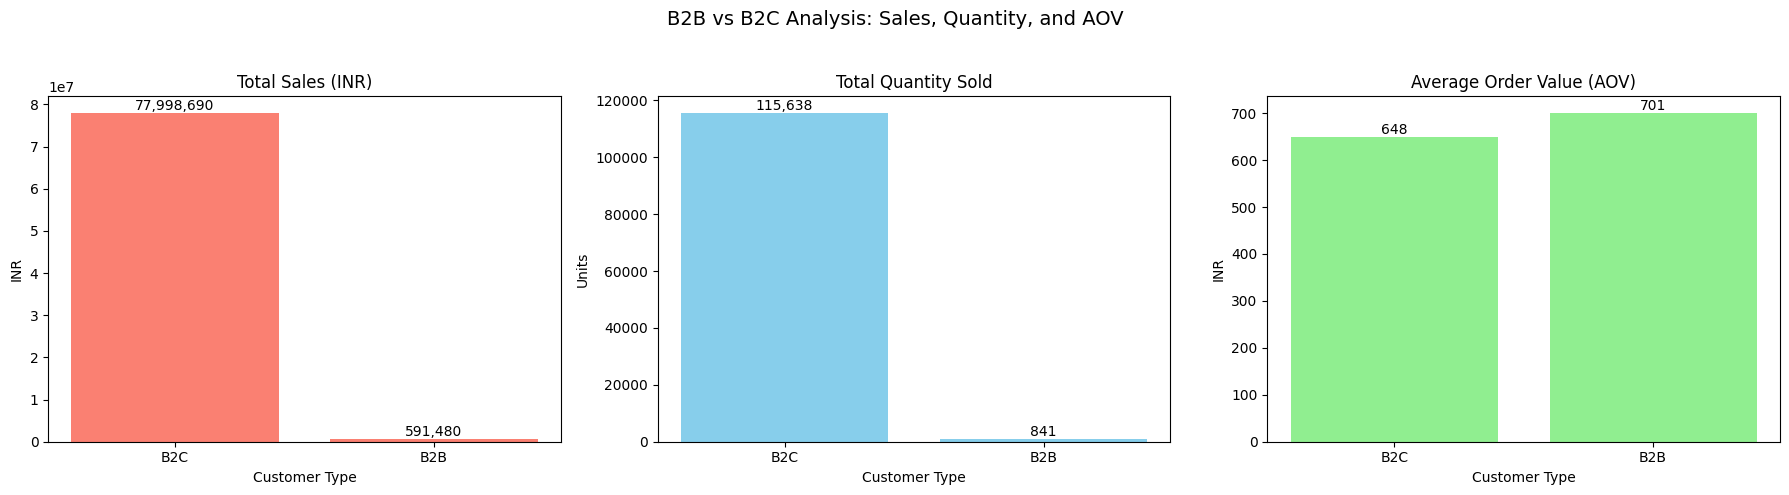

In [24]:
# Sample: assuming b2b_summary DataFrame has 'B2B', 'Total_Sales', 'Total_Quantity', 'AOV'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define custom labels
labels = ['B2C', 'B2B']
x = [0, 1]  # corresponding to False and True

# Plot 1: Total Sales (INR)
bars1 = axes[0].bar(x, b2b_summary['Total_Sales'], color='salmon')
axes[0].set_title("Total Sales (INR)")
axes[0].set_ylabel("INR")
axes[0].set_xlabel("Customer Type")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Total Quantity Sold
bars2 = axes[1].bar(x, b2b_summary['Total_Quantity'], color='skyblue')
axes[1].set_title("Total Quantity Sold")
axes[1].set_ylabel("Units")
axes[1].set_xlabel("Customer Type")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

# Plot 3: AOV
bars3 = axes[2].bar(x, b2b_summary['AOV'], color='lightgreen')
axes[2].set_title("Average Order Value (AOV)")
axes[2].set_ylabel("INR")
axes[2].set_xlabel("Customer Type")
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

# Final Layout
plt.suptitle("B2B vs B2C Analysis: Sales, Quantity, and AOV", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


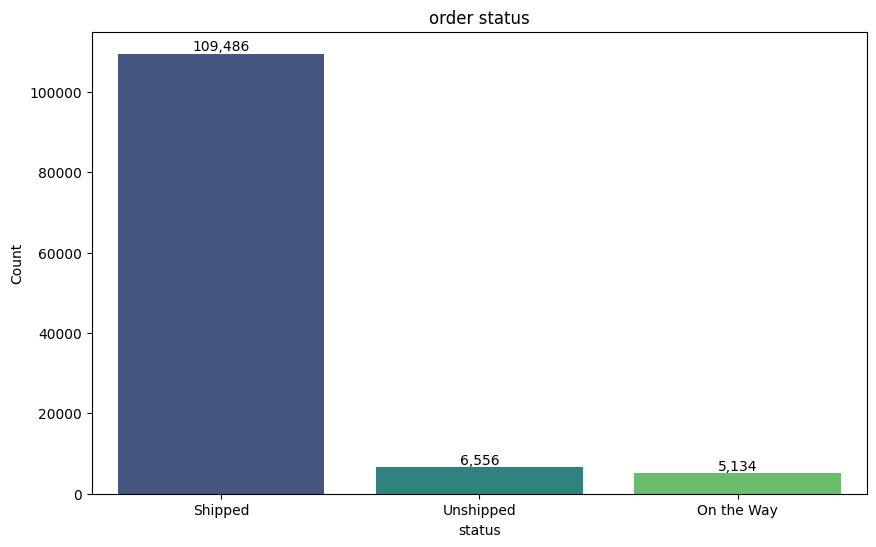

In [25]:
state_counts=df['Courier Status'].value_counts().head(15).reset_index()
plt.figure(figsize=(10, 6))
state_counts.columns = ['Courier Status', 'count']
ax=sns.barplot(data=state_counts, x='Courier Status', y='count',hue='Courier Status',palette='viridis',legend= False)
plt.title('order status')
plt.xlabel('status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, value in enumerate(state_counts['count']):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.show()

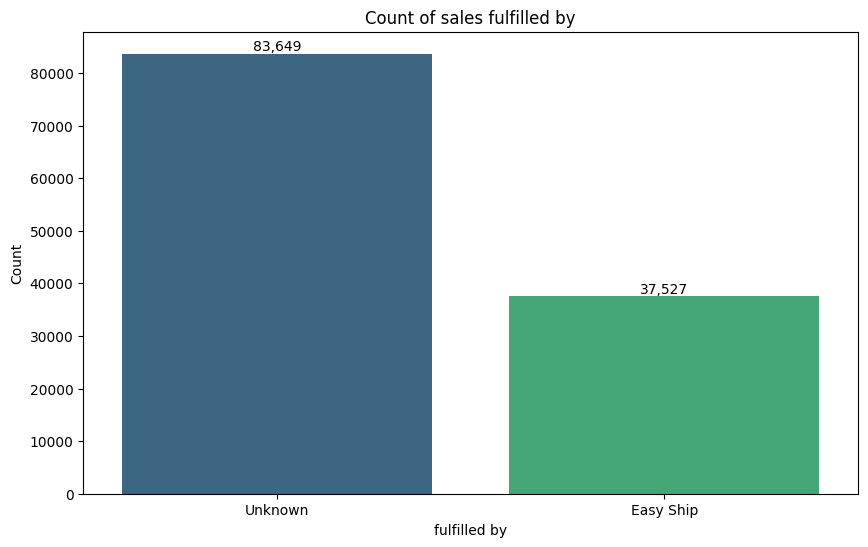

In [26]:
state_counts=df['fulfilled-by'].value_counts().head(15).reset_index()
plt.figure(figsize=(10, 6))
state_counts.columns = ['ship-city', 'count']
ax=sns.barplot(data=state_counts, x='ship-city', y='count',hue='ship-city',palette='viridis',legend= False)
plt.title('Count of sales fulfilled by')
plt.xlabel('fulfilled by')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, value in enumerate(state_counts['count']):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.show()

In [27]:
df['Courier Status'].unique()

array(['On the Way', 'Shipped', 'Unshipped'], dtype=object)

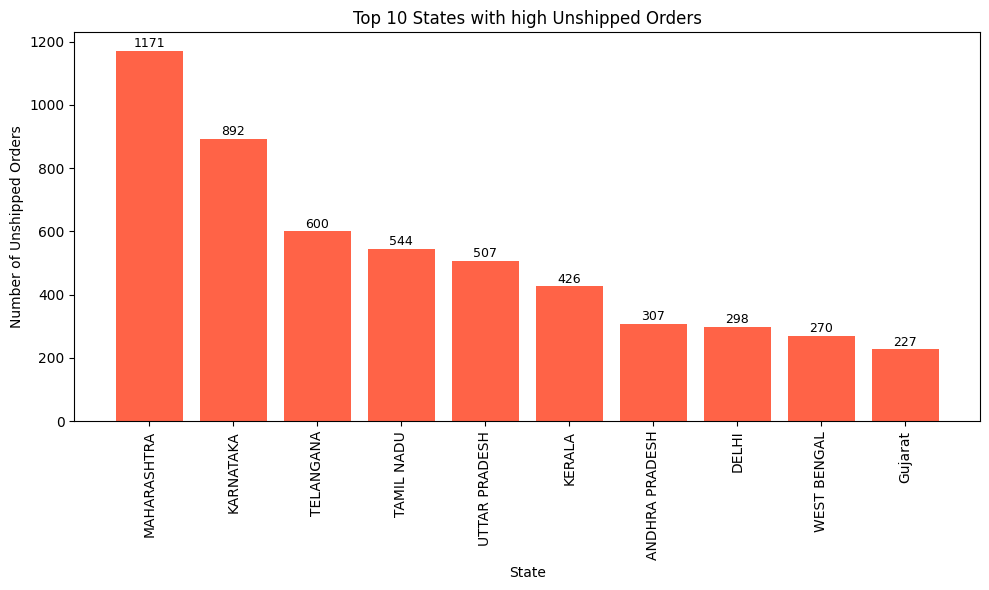

In [28]:
# Filter only unshipped orders
delayed = df[df['Courier Status'] == 'Unshipped']

# Count delays by state
state_delay_counts = delayed['ship-state'].value_counts().head(10)

# Plot vertical bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(state_delay_counts.index, state_delay_counts.values, color='tomato')
plt.xlabel("State")
plt.ylabel("Number of Unshipped Orders")
plt.title("Top 10 States with high Unshipped Orders")

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


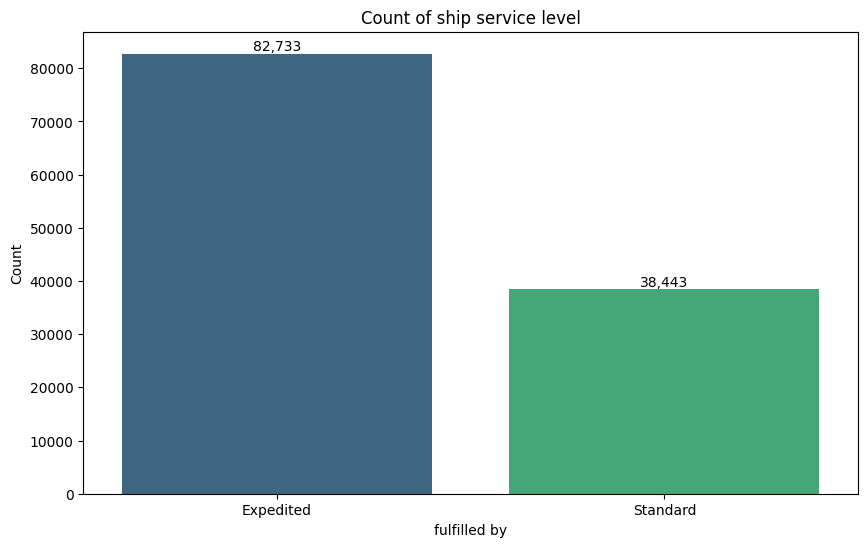

In [29]:
state_counts=df['ship-service-level'].value_counts().head(15).reset_index()
plt.figure(figsize=(10, 6))
state_counts.columns = ['ship-service-level', 'count']
ax=sns.barplot(data=state_counts, x='ship-service-level', y='count',hue='ship-service-level',palette='viridis',legend= False)
plt.title('Count of ship service level')
plt.xlabel('fulfilled by')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, value in enumerate(state_counts['count']):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.show()

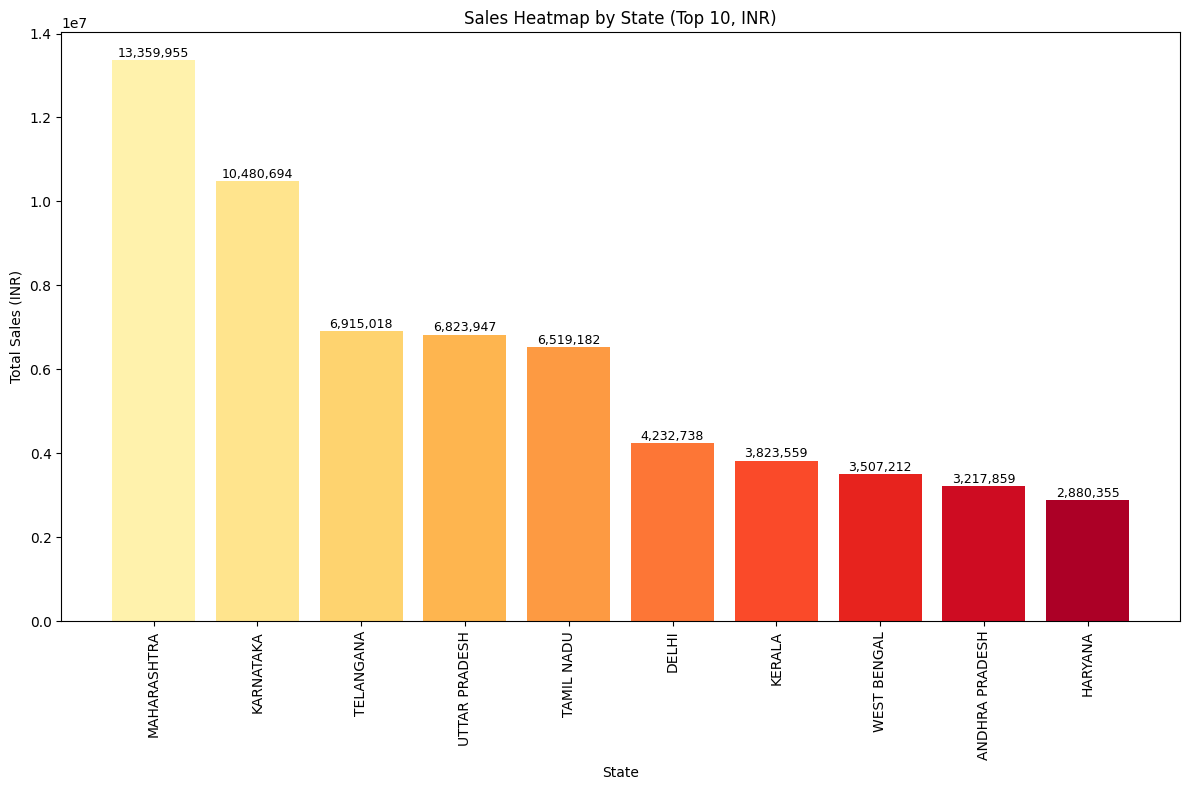

In [30]:
# Step 1: Clean data (only INR sales and non-null)
df_clean = df[(df['currency'] == 'INR') & df['ship-state'].notna() & df['Amount'].notna()]

# Step 2: Aggregate total sales by state
state_sales = df_clean.groupby('ship-state')['Amount'].sum().sort_values(ascending=False).head(10)

# Step 3: Plot vertical bar chart (heatmap style)
plt.figure(figsize=(12, 8))
colors = sns.color_palette("YlOrRd", len(state_sales))
bars = plt.bar(state_sales.index, state_sales.values, color=colors)

plt.xlabel("State")
plt.ylabel("Total Sales (INR)")
plt.title("Sales Heatmap by State (Top 10, INR)")
plt.xticks(rotation=90)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5000,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [31]:
df['ship-country'].unique()

array(['IN', 'International'], dtype=object)

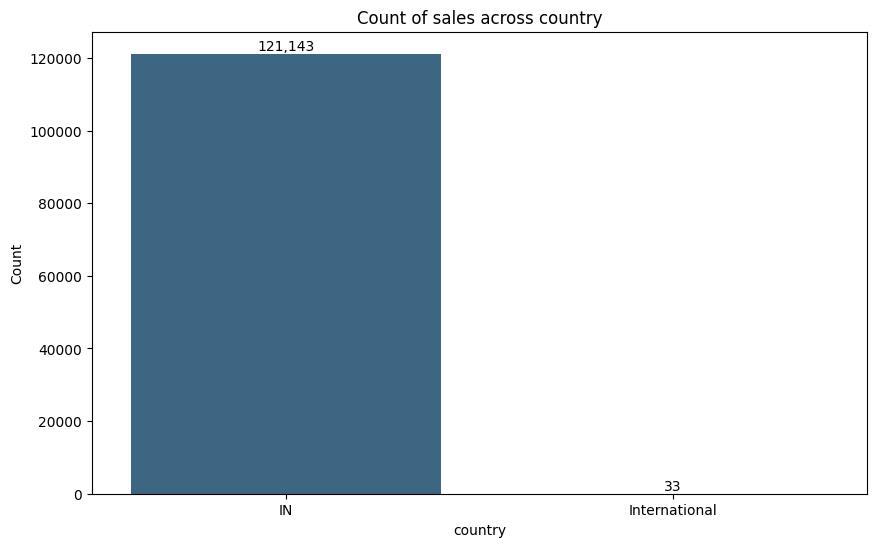

In [32]:
state_counts=df['ship-country'].value_counts().head(15).reset_index()
plt.figure(figsize=(10, 6))
state_counts.columns = ['ship-country', 'count']
ax=sns.barplot(data=state_counts, x='ship-country', y='count',hue='ship-country',palette='viridis',legend= False)
plt.title('Count of sales across country')
plt.xlabel('country')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, value in enumerate(state_counts['count']):
  ax.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)
plt.show()

In [33]:
def categorize_order(value):
    if value < 500:
        return 'Low'
    elif value < 1000:
        return 'Medium'
    else:
        return 'High'

df['Order_Segment'] = df['Amount'].apply(categorize_order)
segment_summary = df.groupby('Order_Segment').agg({
    'Amount': ['count', 'mean', 'median', 'sum'],
    'Qty': 'mean',
    'Order ID': pd.Series.nunique
})

segment_summary.columns = ['Order_Count', 'Avg_Amount', 'Median_Amount', 'Total_Amount', 'Avg_Qty', 'Unique_Orders']
segment_summary = segment_summary.reset_index()
print(segment_summary)


  Order_Segment  Order_Count   Avg_Amount  Median_Amount  Total_Amount  \
0          High        13328  1217.376555         1163.0   16225194.72   
1           Low        43621   384.804174          399.0   16785542.86   
2        Medium        64227   709.661555          699.0   45579432.67   

    Avg_Qty  Unique_Orders  
0  0.992347          12930  
1  0.956283          40986  
2  0.958148          61216  


<ipython-input-34-3359873086>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Order_Segment', y='Order_Count', data=segment_summary, palette='Set2')


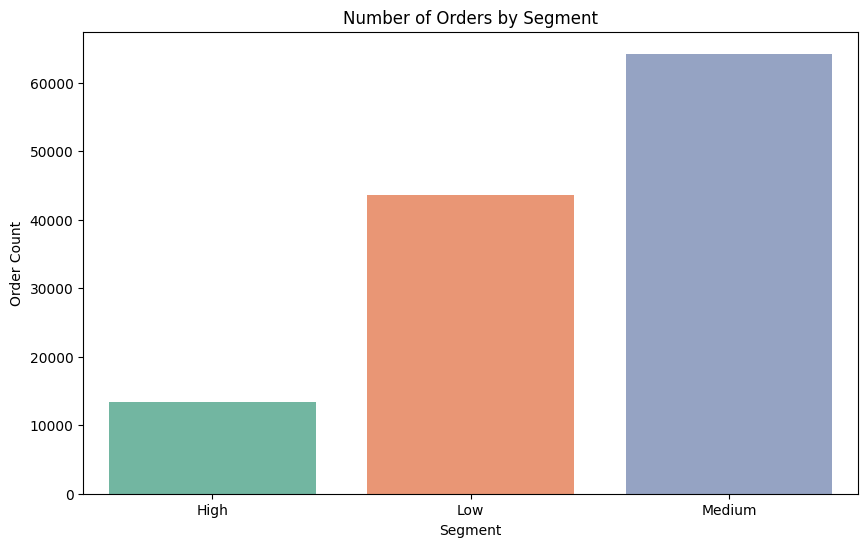

<ipython-input-34-3359873086>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Order_Segment', y='Total_Amount', data=segment_summary, palette='Set1')


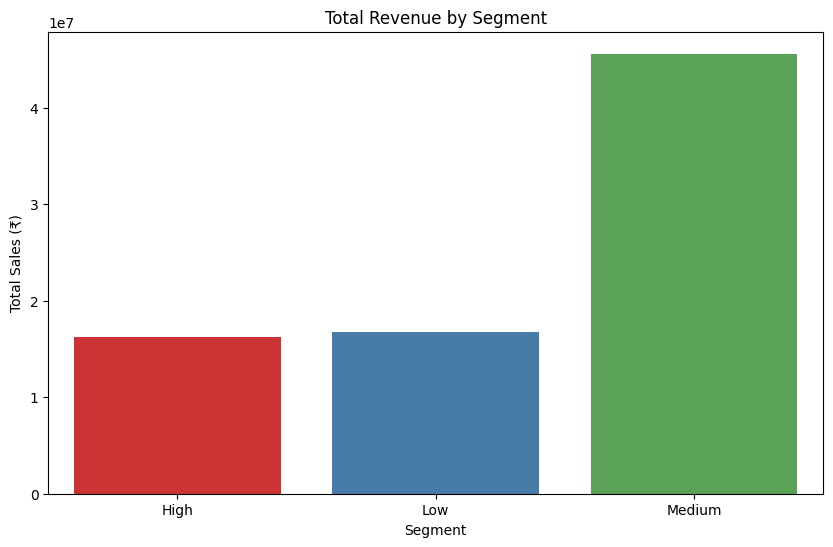

In [34]:
# Barplot - Order Count
plt.figure(figsize=(10,6))
sns.barplot(x='Order_Segment', y='Order_Count', data=segment_summary, palette='Set2')
plt.title('Number of Orders by Segment')
plt.ylabel('Order Count')
plt.xlabel('Segment')
plt.show()

# Barplot - Total Amount
plt.figure(figsize=(10, 6))
sns.barplot(x='Order_Segment', y='Total_Amount', data=segment_summary, palette='Set1')
plt.title('Total Revenue by Segment')
plt.ylabel('Total Sales (₹)')
plt.xlabel('Segment')
plt.show()


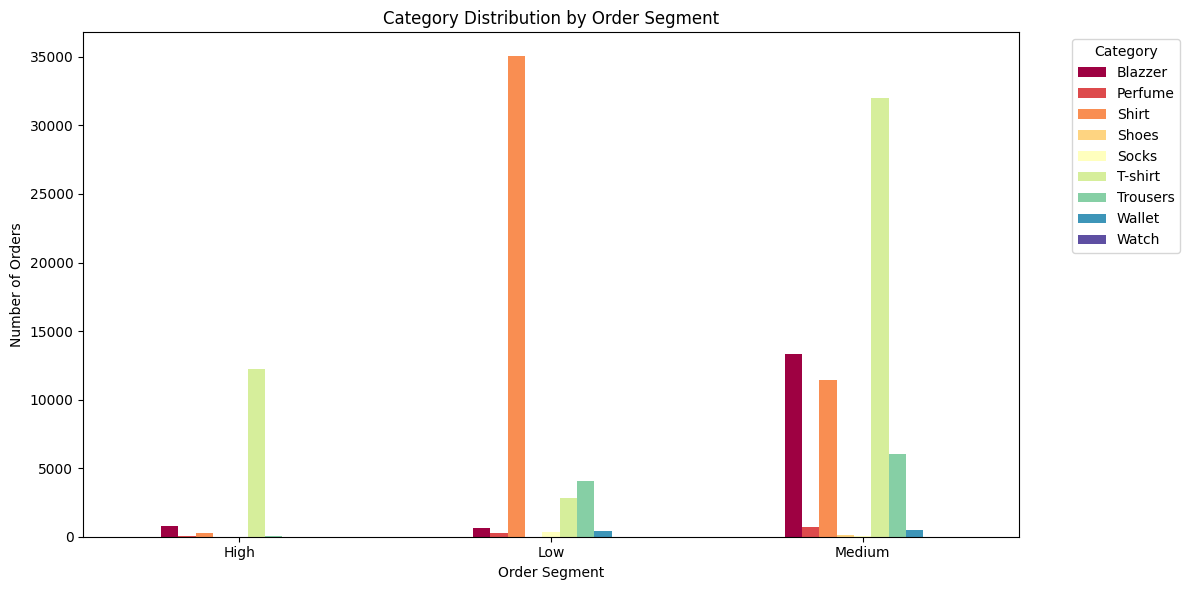

In [35]:
cat_segment = df.groupby(['Order_Segment', 'Category']).size().unstack().fillna(0)

# Side-by-side (grouped) bar plot
cat_segment.plot(kind='bar', stacked=False, figsize=(12, 6), colormap='Spectral')

plt.title('Category Distribution by Order Segment')
plt.xlabel('Order Segment')
plt.ylabel('Number of Orders')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


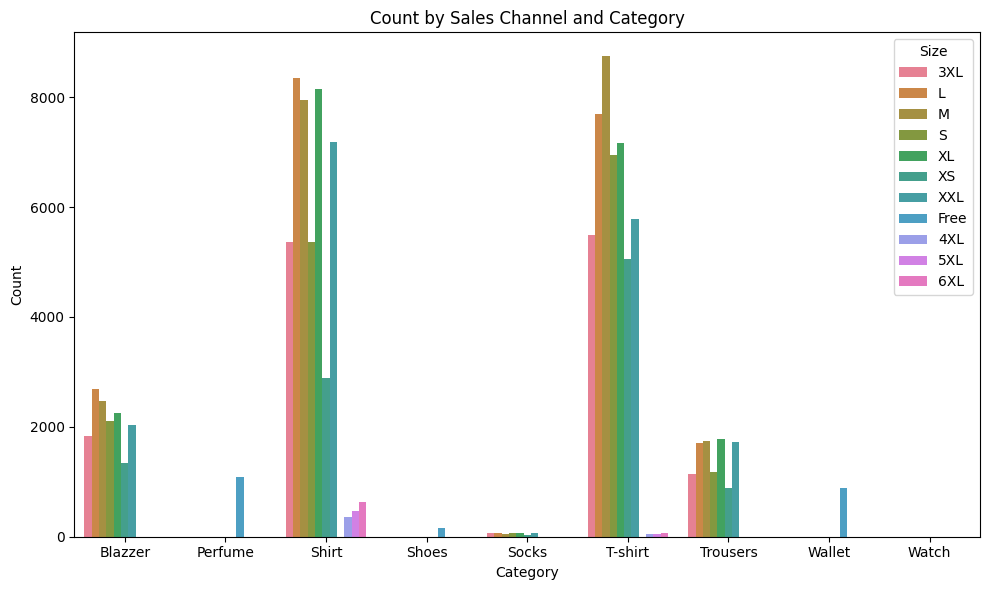

In [36]:
# Group by 'Category' and 'Sales Channel' and count the occurrences
count_data = df.groupby(['Category', 'Size']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=count_data, x='Category', y='Count', hue='Size')
plt.title('Count by Sales Channel and Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [37]:
# Step 1: Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 2: Filter INR orders with non-null data
df_rfm = df[(df['currency'] == 'INR') & df['Amount'].notna() & df['Date'].notna() & df['ship-postal-code'].notna()]


In [38]:
# Snapshot date = last order date + 1
snapshot_date = df_rfm['Date'].max() + pd.Timedelta(days=1)

# Group by ship-postal-code as proxy for Customer_ID
rfm = df_rfm.groupby('ship-postal-code').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                             # Frequency
    'Amount': 'sum'                                    # Monetary
}).reset_index()

rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']


In [39]:
# Score from 1 (low) to 5 (high)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# RFM Segment and Score
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Optional: Tag segments
def tag_segment(score):
    if score >= 9:
        return 'Champions'
    elif score >= 8:
        return 'Loyal'
    elif score >= 6:
        return 'Potential'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(tag_segment)

print(rfm)

      Customer_ID  Recency  Frequency  Monetary  R  F  M RFM_Segment  \
0        110001.0        9         46  34573.86  4  5  5         455   
1        110002.0        2         34  25620.14  5  5  5         555   
2        110003.0        2         56  36144.10  5  5  5         555   
3        110004.0       48          1    814.00  2  1  2         212   
4        110005.0        1         61  40534.25  5  5  5         555   
...           ...      ...        ...       ... .. .. ..         ...   
9263     855115.0       61          2   1809.00  1  3  3         133   
9264     855116.0       89          1   2066.00  1  2  3         123   
9265     855117.0       26          1    797.00  3  2  2         322   
9266     984196.0       42          1    734.29  2  2  1         221   
9267     989898.0       64          1    380.00  1  2  1         121   

      RFM_Score    Segment  
0            14  Champions  
1            15  Champions  
2            15  Champions  
3             5    

<ipython-input-40-3328157766>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='coolwarm')


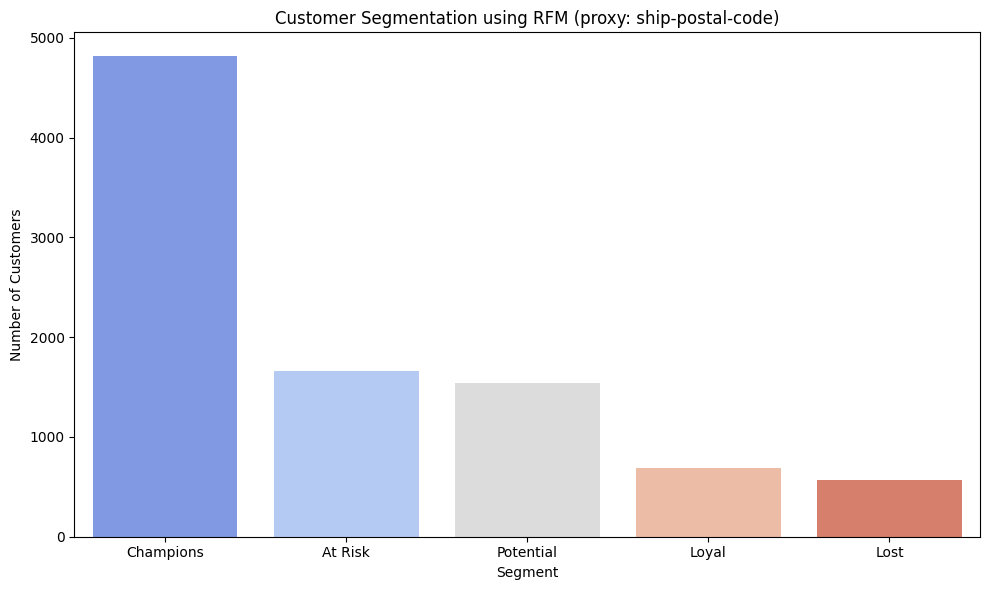

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='coolwarm')
plt.title('Customer Segmentation using RFM (proxy: ship-postal-code)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


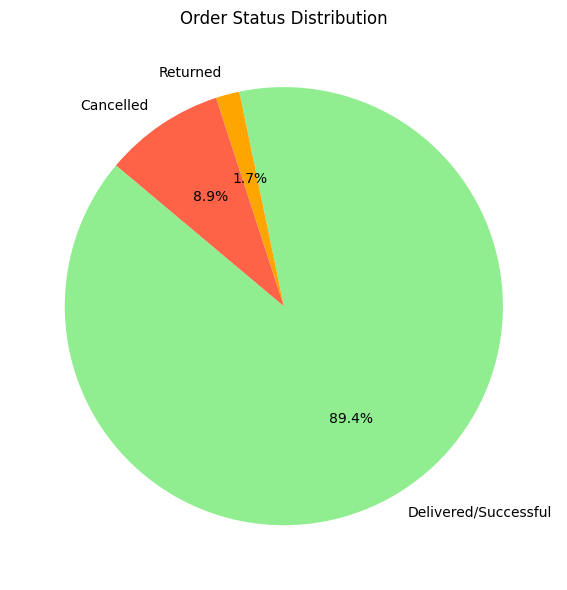

Total Orders: 121176
Returned Orders: 2113 (1.74%)
Cancelled Orders: 10763 (8.88%)


In [41]:
# Define returned and cancelled statuses
returned_statuses = [
    'Shipped - Returned to Seller',
    'Shipped - Rejected by Buyer',
    'Shipped - Returning to Seller',
    'Shipped - Damaged',
    'Shipped - Lost in Transit'
]

cancelled_statuses = ['Cancelled']

# Total orders
total_orders = len(df)

# Count returns & cancellations
num_returned = df['Status'].isin(returned_statuses).sum()
num_cancelled = df['Status'].isin(cancelled_statuses).sum()
num_successful = total_orders - num_returned - num_cancelled

# Percentages
return_rate = (num_returned / total_orders) * 100
cancel_rate = (num_cancelled / total_orders) * 100
success_rate = (num_successful / total_orders) * 100

# Prepare for plotting
status_labels = ['Delivered/Successful', 'Returned', 'Cancelled']
status_values = [num_successful, num_returned, num_cancelled]

# Plot
plt.figure(figsize=(8, 6))
colors = ['lightgreen', 'orange', 'tomato']
plt.pie(status_values, labels=status_labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Order Status Distribution")
plt.tight_layout()
plt.show()

# Print values
print(f"Total Orders: {total_orders}")
print(f"Returned Orders: {num_returned} ({return_rate:.2f}%)")
print(f"Cancelled Orders: {num_cancelled} ({cancel_rate:.2f}%)")


Total Orders: 121176
Outliers Detected: 3601
Q1:449.0
Q3:788.0
IQR:339.0
lower bound:-59.5
upper bound:1296.5


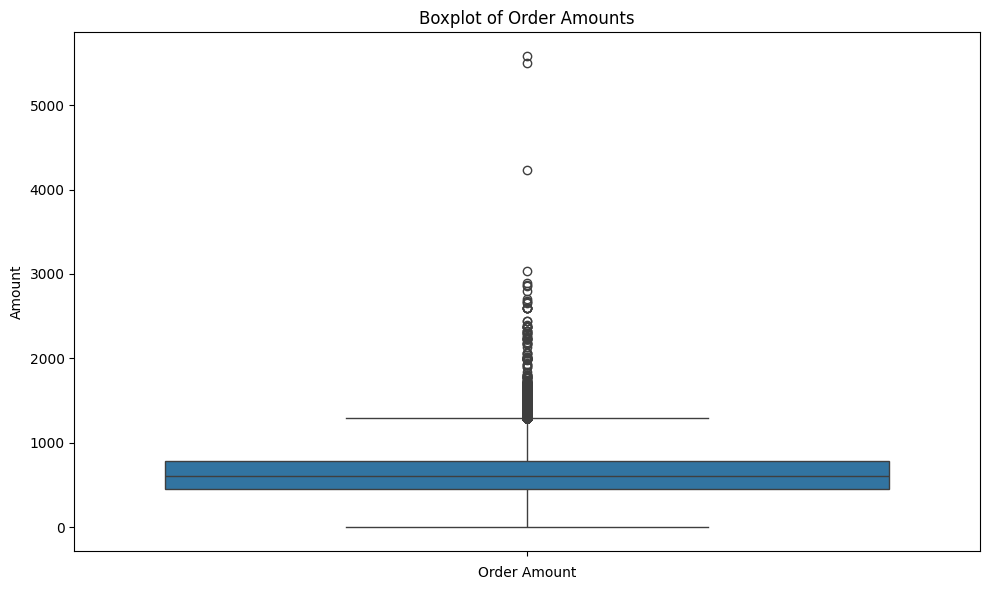

In [42]:
# Step 1: Filter valid INR amount entries
df_amount = df[(df['Amount'].notnull())]

# Step 2: Calculate IQR
Q1 = df_amount['Amount'].quantile(0.25)
Q3 = df_amount['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Step 3: Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Flag outliers
df_amount['Outlier'] = ((df_amount['Amount'] < lower_bound) | (df_amount['Amount'] > upper_bound))

# Step 5: Summary
print(f"Total Orders: {len(df_amount)}")
print(f"Outliers Detected: {df_amount['Outlier'].sum()}")
print(f"Q1:{Q1}")
print(f"Q3:{Q3}")
print(f"IQR:{IQR}")
print(f"lower bound:{lower_bound}")
print(f"upper bound:{upper_bound}")
# Step 6: Boxplot Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_amount['Amount'])
plt.title("Boxplot of Order Amounts")
plt.xlabel("Order Amount")
plt.tight_layout()
plt.show()


In [43]:

# Step 1: Calculate Z-scores
df_amount['Z_Score'] = zscore(df_amount['Amount'])

# Step 2: Flag outliers (threshold > 3 or < -3)
df_amount['Z_Outlier'] = (df_amount['Z_Score'].abs() > 3)

# Step 3: Count
print(f"Outliers using Z-Score: {df_amount['Z_Outlier'].sum()}")


Outliers using Z-Score: 785


IQR Outlier:3601
Z-Score Outlier:785


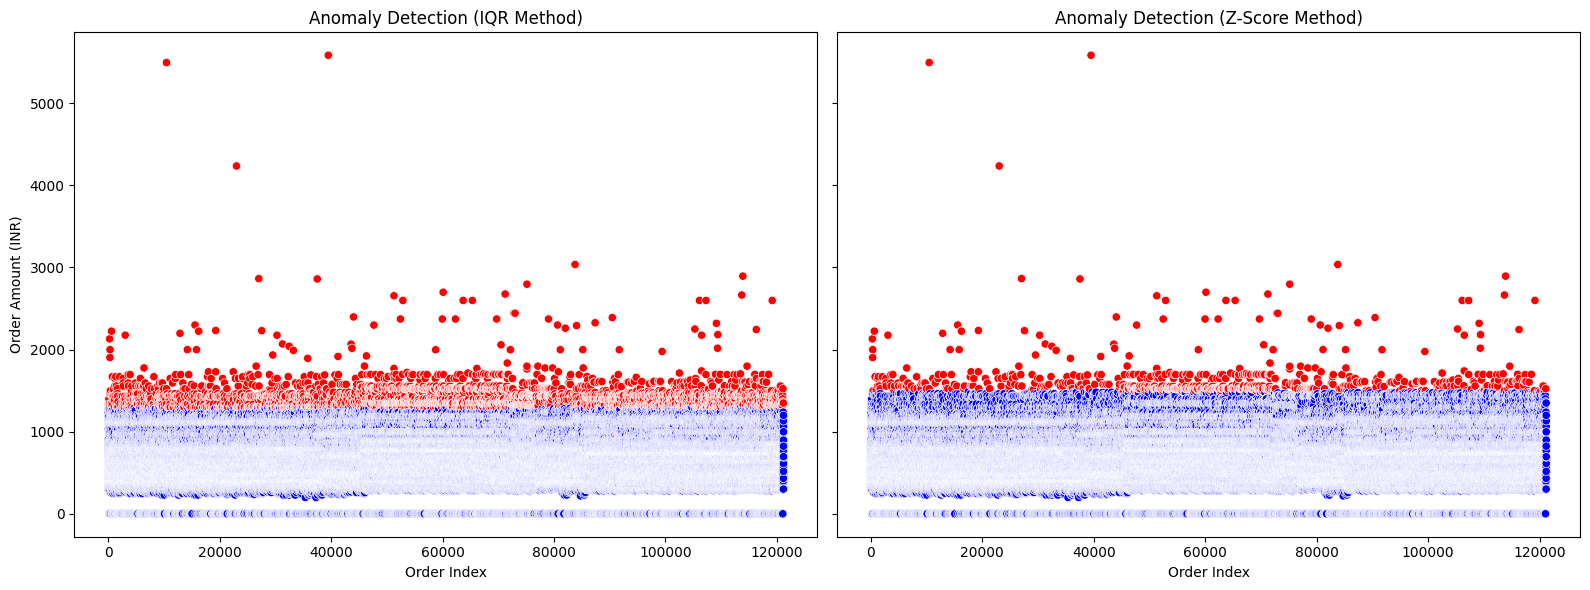

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# IQR Plot
sns.scatterplot(
    data=df_amount,
    x=range(len(df_amount)),
    y='Amount',
    hue='Outlier',
    palette={True: 'red', False: 'blue'},
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Anomaly Detection (IQR Method)")
axes[0].set_xlabel("Order Index")
axes[0].set_ylabel("Order Amount (INR)")

# Z-Score Plot
sns.scatterplot(
    data=df_amount,
    x=range(len(df_amount)),
    y='Amount',
    hue='Z_Outlier',
    palette={True: 'red', False: 'blue'},
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Anomaly Detection (Z-Score Method)")
axes[1].set_xlabel("Order Index")
print(f"IQR Outlier:{df_amount['Outlier'].sum()}")
print(f"Z-Score Outlier:{df_amount['Z_Outlier'].sum()}")
plt.tight_layout()
plt.show()

## **Independent sample T-Test**

In [45]:
# Prepare data
df_ttest = df[['Amount', 'B2B']].dropna()
amount_b2b = df_ttest[df_ttest['B2B'] == True]['Amount']
amount_b2c = df_ttest[df_ttest['B2B'] == False]['Amount']

# Perform t-test
t_stat, p_val = ttest_ind(amount_b2b, amount_b2c)

print(f"T-Test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# Interpretation
if p_val < 0.05:
    print("👉 There is a statistically significant difference in Amount between B2B and B2C orders.")
else:
    print("👉 There is no statistically significant difference in Amount between B2B and B2C orders.")


T-Test Results:
T-statistic: 5.4172
P-value: 0.0000
👉 There is a statistically significant difference in Amount between B2B and B2C orders.


## **ANOVA Test**

In [46]:

# Prepare data
df_anova = df[['Amount', 'Category']].dropna()
groups = [group['Amount'].values for _, group in df_anova.groupby('Category')]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)

print(f"\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# Interpretation
if p_val < 0.05:
    print("👉 There is a statistically significant difference in mean Amount across at least one Category.")
else:
    print("👉 There is no statistically significant difference in mean Amount across Categories.")



ANOVA Results:
F-statistic: 9711.5470
P-value: 0.0000
👉 There is a statistically significant difference in mean Amount across at least one Category.


## **Chi-Square Test**

In [47]:

import pandas as pd

# Create a contingency table
contingency_table = pd.crosstab(df['Status'], df['Courier Status'])

# Perform Chi-Square Test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2_stat:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p_val:.4f}")

# Interpretation
if p_val < 0.05:
    print("👉 There is a statistically significant association between Status and Courier Status.")
else:
    print("👉 There is no statistically significant association between Status and Courier Status.")


Chi-Square Test Results:
Chi2 Statistic: 129156.0567
Degrees of Freedom: 22
P-value: 0.0000
👉 There is a statistically significant association between Status and Courier Status.


In [48]:

# Drop nulls
df_corr = df[['Qty', 'Amount']].dropna()

# Pearson Correlation
pearson_corr, pearson_p = pearsonr(df_corr['Qty'], df_corr['Amount'])

print("📊 Pearson Correlation Test:")
print(f"Correlation Coefficient: {pearson_corr:.4f}")
print(f"P-value: {pearson_p:.4f}")
if pearson_p < 0.05:
    print("👉 There is a statistically significant linear correlation between Qty and Amount.")
else:
    print("👉 There is no statistically significant linear correlation between Qty and Amount.")

# Spearman Correlation (non-parametric)
spearman_corr, spearman_p = spearmanr(df_corr['Qty'], df_corr['Amount'])

print("\n📊 Spearman Correlation Test:")
print(f"Correlation Coefficient: {spearman_corr:.4f}")
print(f"P-value: {spearman_p:.4f}")
if spearman_p < 0.05:
    print("👉 There is a statistically significant monotonic correlation between Qty and Amount.")
else:
    print("👉 There is no statistically significant monotonic correlation between Qty and Amount.")


📊 Pearson Correlation Test:
Correlation Coefficient: 0.0667
P-value: 0.0000
👉 There is a statistically significant linear correlation between Qty and Amount.

📊 Spearman Correlation Test:
Correlation Coefficient: 0.0398
P-value: 0.0000
👉 There is a statistically significant monotonic correlation between Qty and Amount.


## **Normality Test**

In [49]:

# Drop NaNs
amount_data = df['Amount'].dropna()
qty_data = df['Qty'].dropna()

# Shapiro-Wilk test for 'Amount'
shapiro_stat_amt, p_amt = shapiro(amount_data)
print("📊 Shapiro-Wilk Test for 'Amount':")
print(f"Statistic: {shapiro_stat_amt:.4f}")
print(f"P-value: {p_amt:.4f}")
if p_amt < 0.05:
    print("👉 'Amount' does not follow a normal distribution.")
else:
    print("👉 'Amount' appears normally distributed**.")

# Shapiro-Wilk test for 'Qty'
shapiro_stat_qty, p_qty = shapiro(qty_data)
print("\n📊 Shapiro-Wilk Test for 'Qty':")
print(f"Statistic: {shapiro_stat_qty:.4f}")
print(f"P-value: {p_qty:.4f}")
if p_qty < 0.05:
    print("👉 'Qty' does not follow a normal distribution.")
else:
    print("👉 'Qty' appears normally distributed")


📊 Shapiro-Wilk Test for 'Amount':
Statistic: 0.9500
P-value: 0.0000
👉 'Amount' does not follow a normal distribution.

📊 Shapiro-Wilk Test for 'Qty':
Statistic: 0.2248
P-value: 0.0000
👉 'Qty' does not follow a normal distribution.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 121176.
  res = hypotest_fun_out(*samples, **kwds)


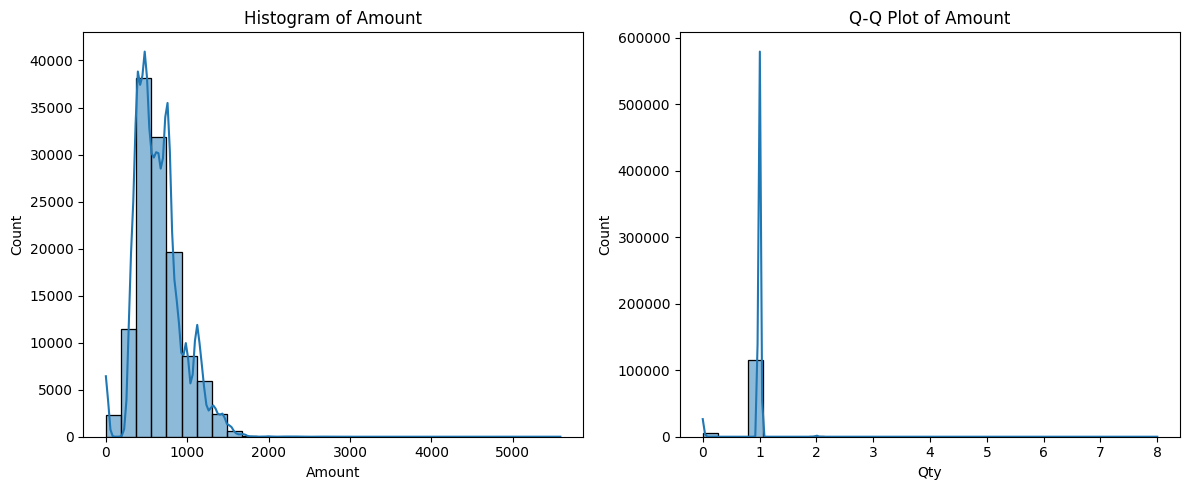

In [50]:
plt.figure(figsize=(12, 5))

# Histogram for 'Amount'
plt.subplot(1, 2, 1)
sns.histplot(amount_data, kde=True, bins=30)
plt.title("Histogram of Amount")

# Q-Q Plot for 'Qty'
plt.subplot(1, 2, 2)
sns.histplot(qty_data, kde=True, bins=30)
plt.title("Q-Q Plot of Amount")

plt.tight_layout()
plt.show()


In [51]:
# Drop missing values
amount_data = df['Amount'].dropna()
qty_data = df['Qty'].dropna()

# Anderson-Darling test for 'Amount'
result_amt = anderson(amount_data, dist='norm')
print("📊 Anderson-Darling Test for 'Amount':")
print(f"Statistic: {result_amt.statistic:.4f}")
for i in range(len(result_amt.critical_values)):
    sig_level = result_amt.significance_level[i]
    critical = result_amt.critical_values[i]
    if result_amt.statistic < critical:
        print(f"At {sig_level}% significance level: Data appears normal (statistic < critical value)")
    else:
        print(f"At {sig_level}% significance level: Data does not appear normal (statistic >= critical value)")

# Anderson-Darling test for 'Qty'
result_qty = anderson(qty_data, dist='norm')
print("\n📊 Anderson-Darling Test for 'Qty':")
print(f"Statistic: {result_qty.statistic:.4f}")
for i in range(len(result_qty.critical_values)):
    sig_level = result_qty.significance_level[i]
    critical = result_qty.critical_values[i]
    if result_qty.statistic < critical:
        print(f"At {sig_level}% significance level: Data appears normal (statistic < critical value)")
    else:
        print(f"At {sig_level}% significance level: Data does not appear normal (statistic >= critical value)")


📊 Anderson-Darling Test for 'Amount':
Statistic: 1623.6805
At 15.0% significance level: Data does not appear normal (statistic >= critical value)
At 10.0% significance level: Data does not appear normal (statistic >= critical value)
At 5.0% significance level: Data does not appear normal (statistic >= critical value)
At 2.5% significance level: Data does not appear normal (statistic >= critical value)
At 1.0% significance level: Data does not appear normal (statistic >= critical value)

📊 Anderson-Darling Test for 'Qty':
Statistic: 43005.5870
At 15.0% significance level: Data does not appear normal (statistic >= critical value)
At 10.0% significance level: Data does not appear normal (statistic >= critical value)
At 5.0% significance level: Data does not appear normal (statistic >= critical value)
At 2.5% significance level: Data does not appear normal (statistic >= critical value)
At 1.0% significance level: Data does not appear normal (statistic >= critical value)


## **Mann-Whitney U Test**

In [52]:

# Prepare data
df_mw = df[['Amount', 'B2B']].dropna()
amount_b2b = df_mw[df_mw['B2B'] == True]['Amount']
amount_b2c = df_mw[df_mw['B2B'] == False]['Amount']

# Mann-Whitney U test
u_stat, p_val = mannwhitneyu(amount_b2b, amount_b2c, alternative='two-sided')

print("📊 Mann–Whitney U Test (B2B vs B2C Amount):")
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("👉 Significant difference in Amount between B2B and B2C (non-parametric).")
else:
    print("👉 No significant difference in Amount between B2B and B2C (non-parametric).")


📊 Mann–Whitney U Test (B2B vs B2C Amount):
U-statistic: 55184064.5000
P-value: 0.0000
👉 Significant difference in Amount between B2B and B2C (non-parametric).


## **Kruskal-Wallis Test**

In [53]:

# Drop nulls
df_kruskal = df[['Amount', 'Category']].dropna()

# Create grouped data
grouped = [group['Amount'].values for _, group in df_kruskal.groupby('Category')]

# Kruskal–Wallis test
h_stat, p_val = kruskal(*grouped)

print("\n📊 Kruskal–Wallis Test (Amount by Category):")
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("👉 At least one category differs significantly in Amount.")
else:
    print("👉 No significant difference in Amount across categories.")



📊 Kruskal–Wallis Test (Amount by Category):
H-statistic: 61361.9888
P-value: 0.0000
👉 At least one category differs significantly in Amount.
